# Experiment 5

First successful attemp of reproducing GASP with simulation

In [1]:
import sys
sys.path.insert(0, '../../')

import math
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.animation as animation
from skimage.filters import threshold_li
from gasp import ssfp, phantom, tissue, responses, gasp as GASP

In [2]:
# Experiment parameters
T1, T2 = 1.2, .035
TR, alpha = 5e-3, np.deg2rad(30)
TE = TR / 2.0
BetaMax = 2 * np.pi
npcs = 16
pcs = np.linspace(0, 2*np.pi, npcs, endpoint=False)
width = 256
height = 256
TRs = [5e-3, 10e-3, 15e-3]
nTRs = len(TRs)

In [3]:
img = phantom.phantom_generator(type='circle')
t = tissue.tissue_generator(type='circle')
mask = t['mask']
size = mask.shape
t1 = t['t1']
t2 = t['t2']
beta = np.linspace(-BetaMax, BetaMax, size[1])
f = beta / TR / (2 * np.pi)
f = np.tile(f, (size[0], 1))

In [4]:
width = 256
height = 256
TRs = [5e-3, 10e-3, 15e-3]
nTRs = len(TRs)
M = np.empty((height, width, npcs,  nTRs), dtype=np.complex128)

for ii, TR in enumerate(TRs):
    TE = TR / 2.0
    M[..., ii] = ssfp.ssfp(t1, t2, TR, TE, alpha, pcs, field_map=f, M0 = mask)

M = np.reshape(M, (height, width, 1, npcs,  nTRs))
M.shape

(256, 256, 1, 16, 3)

In [5]:
# Create mask of phantom
_ = np.sqrt(np.sum(np.abs(M)**2, axis=2))
_ = np.mean(_, axis=2)
_ = np.mean(_, axis=2)
_ = abs(_)
thresh = threshold_li(_)
mask = np.abs(_) > thresh
print(mask.shape)

# Apply mask to data
mask0 = np.tile(
    mask, (M.shape[2:] + (1, 1,))).transpose((3, 4, 0, 1, 2))
data = M * mask0
print(data.shape)

(256, 256)
(256, 256, 1, 16, 3)


C:\Users\mmend\.conda\envs\mri\lib\site-packages\skimage\filters\thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))


In [6]:
data = np.reshape(data, data.shape[:-2] + (-1,))    # [Height, Width, Coil, PCs x TRs]
data = np.moveaxis(data, 2, 0)                      # [Coil, Height, Width, PCs x TRs]
data = data.transpose((0, 3, 1, 2))                 # [Coil,  PCs x TRs, Width,   Height]
print(data.shape)

# Get new dimensions
ncoils, npcs, height, width = data.shape[:]

# Calibration box - (# Number of lines of calibration, Pixels on signal)
C_dim = (32, width)

(1, 48, 256, 256)


44 83


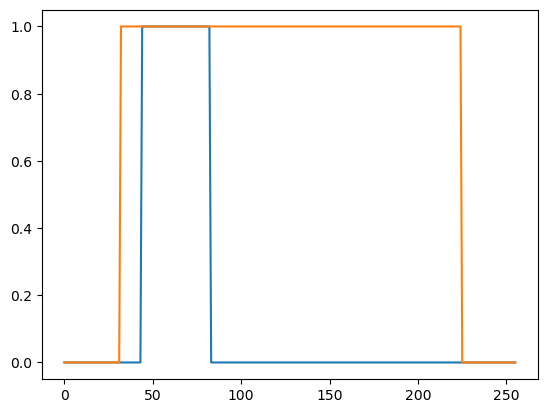

In [7]:
# Create forcing function
test = 2
if test == 0:
    #D = responses.triangle_periodic(width, 120, 110, 38)
    #D = responses.triangle_periodic(width, 150, 75, 100)
    D = responses.triangle_periodic(width, 120, 50, 38)
    D *= mask.T[int(height/2), :]
if test == 1:
    bw = 0.1
    shift = 0.5
    x0 = -1/bw * shift
    x = np.linspace(-1/bw + x0, 1/bw + x0, width)
    D = np.sinc(x)
if test == 2:
    bw = 0.15
    shift = -0.25
    bandpass = np.zeros(width)
    bw = width * bw
    x0 = shift * width
    xlo = int(width/2-bw/2+x0)
    xhi = int(width/2+bw/2+x0)
    bandpass[xlo:xhi] = 1
    print(xlo, xhi)
    D = bandpass

plt.plot(D)
plt.plot(mask[:, int(width/2)])
plt.show()

In [8]:
Ic = np.zeros((ncoils, height, width), dtype='complex')
for cc in range(ncoils):
    Ic[cc, ...] = GASP.gasp(data[cc, ...], D, C_dim, pc_dim=0)
Ic = np.sqrt(np.sum(np.abs(Ic)**2, axis=0))

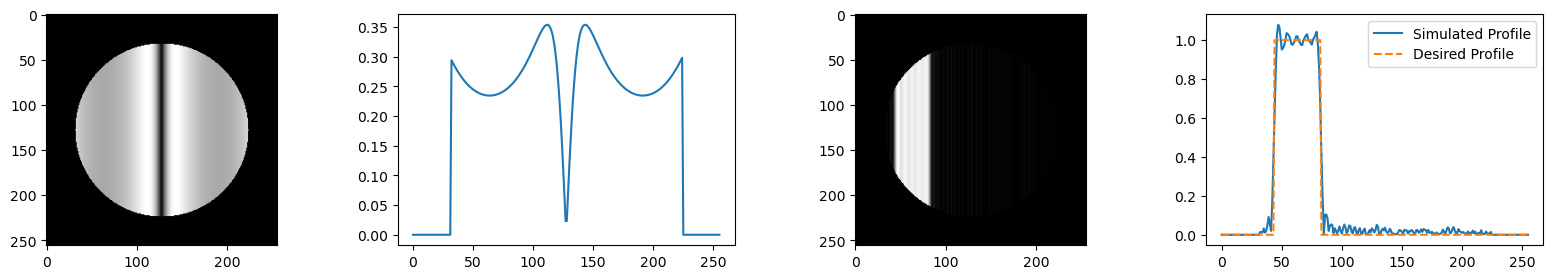

In [9]:
_ = np.sqrt(np.sum(abs(data[:, 0, ...])**2, axis=0))

f = plt.figure(figsize=(20,3))
ax = f.add_subplot(141)
ax2 = f.add_subplot(142)
ax3 = f.add_subplot(143)
ax4 = f.add_subplot(144)

ax.imshow(_, cmap='gray')
ax2.plot(_[int(width/2), :])
ax3.imshow(Ic, cmap='gray')
ax4.plot(np.abs(Ic[int(height/2), :]), label='Simulated Profile')
ax4.plot(D, '--', label='Desired Profile')
ax4.legend()

plt.show()